In [1]:
import xarray as xr
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xskillscore
import pickle
from xskillscore import crps_ensemble, crps_gaussian
import properscoring as ps
module_path = '/home/jupyter-aaron/Postprocessing/PP_EUPP'
if module_path not in sys.path:
    sys.path.append(module_path)
from Transformer import StackedTransformer
from utils.metrics import CrpsGaussianLoss, CrpsGaussianTruncatedLoss

In [2]:
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds
def z_normalize(ds):
    for var in ds.data_vars:
        for day in range(len(dummy.time)):
                mean = ds.isel(time=day)[var].mean().item()
                std = ds.isel(time=day)[var].std().item()
                ds.isel(time=day)[var] = (ds.isel(time=day)[var] - mean) / (std)
    return ds
def fair_crps_ensemble(observations, forecasts, axis=0):

    # Convert inputs to numpy arrays if they're not already
    forecasts = np.asarray(forecasts)
    observations = np.asarray(observations)
    if axis != 1:
        forecasts = np.moveaxis(forecasts, axis, 1)
    
    # Get number of ensemble members
    m = forecasts.shape[1]
    
    # Calculate dxy: sum of absolute differences between forecasts and observations
    # Add a dimension to observations to allow broadcasting
    observations_expanded = np.expand_dims(observations, axis=1)
    dxy = np.sum(np.abs(forecasts - observations_expanded), axis=1)
    
    # Calculate dxx: sum of absolute differences between all pairs of ensemble members
    # Add dimensions to enable broadcasting for pairwise differences
    forecast_i = np.expand_dims(forecasts, axis=2)  # [batch, ens, 1, ...]
    forecast_j = np.expand_dims(forecasts, axis=1)  # [batch, 1, ens, ...]
    dxx = np.sum(np.abs(forecast_i - forecast_j), axis=(1, 2))
    
    # Calculate CRPS using the kernel approximation formula
    crps = dxy / m - dxx / (m * (m - 1) * 2)
    
    return crps

## Test trained models on 2017 data

### Data preparation

In [3]:
test_rfcs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_observation.nc")

In [4]:
target='w100'  #t2m, w10 or w100 
obs = obs.rename({"w100_obs": "w100"})
obs=obs[target]
test_rfcs=test_rfcs.drop_vars([ "sd", "mx2t6", "mn2t6"])

In [5]:
#add orography as a variable
oro=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/oro.nc") 
dims={'time' : test_rfcs['time'],
       'number': test_rfcs['number'],
       'step': test_rfcs['step']}
xds_oro=oro.expand_dims(time=dims['time'], number=dims['number'],step=dims['step'])
dummy_oro=xr.Dataset(coords=dims)
final_oro=xds_oro.broadcast_like(dummy_oro)

In [6]:
fcs_10=xr.merge([test_rfcs,final_oro])
dummy=xr.merge([test_rfcs,final_oro])

In [7]:
#normalizing
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800)}
# Function to normalize using vectorized operations
dummy_norm=minmax_normalize(dummy,min_max_values)
fcs_norm=dummy_norm

In [8]:
 %reload_ext autoreload
model =  StackedTransformer(num_blocks=4, n_data_shape=(20, 32, 33, 15), n_heads=8,mlp_mult=4,projection_channels=64)

### Actual testing

In [9]:
#this is where the last run is stored 
#checkpoint_path = f'/home/jupyter-aaron/Postprocessing/PP_EUPP/results/Transformerweights/{target}/lr0.001epochs25b2heads8mlt4Stack464predictors15CRPSKERNEL_noexp.pth'
checkpoint_path = '/home/jupyter-ayoub/results/Transformerweights/w100/epochs50predictors15CRPSlambda0.02k3.3.pth'
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model_state_dict = checkpoint['model']
new_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1551969


In [10]:
#turn the normalized reforecasts into a tensor
fcs_norm_whole= fcs_norm.to_array(dim='variable')
rearranged_10= fcs_norm_whole.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_tensor=torch.tensor(rearranged_10.values)
print(fcs_whole_tensor.shape) 

torch.Size([209, 11, 20, 32, 33, 15])


In [11]:
#same for unnormalized data, because I need them for the rescaling 
fcs_array_10 =fcs_10.to_array(dim='variable')
fcs_rearranged_10= fcs_array_10.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_notnorm_tensor=torch.tensor(fcs_rearranged_10.values)
print(fcs_whole_notnorm_tensor.shape)

torch.Size([209, 11, 20, 32, 33, 15])


In [12]:
import torch
postpro_10_whole = torch.empty((209,11,20,32,33,1))

# Apply model in chunks of 10
with torch.no_grad():
    for i in range(0, 209, 2):
        # Get the end index for this chunk
        end = min(i + 2, 209)  # Ensure we don't go out of bounds

        # Apply the model to the chunk and store in the corresponding location in postpro_10_whole
        postpro_10_whole[i:end] = model(fcs_whole_tensor[i:end])


In [41]:
Tformer_all=torch.load("Tformer_w100_all.pt")

In [13]:
MBM_one=np.empty((209,11,20,32,33),dtype=np.float32)
for i in range(20):
    mbm=np.load(f"/home/jupyter-aaron/Postprocessing/PP_EUPP/ClassicalMBM/resultsClassicalMBM/w100/MBM_w100_{i}_pred1.npy")
    MBM_one[:,:,i,:,:]=mbm.squeeze()
MBM_one=np.transpose(MBM_one,(1,0,2,3,4))
MBM_all=np.empty((209,11,3,32,33),dtype=np.float32)
for i in range(3):
     mbm=np.load(f"/home/jupyter-aaron/Postprocessing/PP_EUPP/ClassicalMBM/resultsClassicalMBM/w100/MBM_w100_{i}_pred14.npy")
     MBM_all[:,:,i,:,:]=mbm.squeeze()


In [14]:
MBM_all.shape

(209, 11, 3, 32, 33)

In [16]:
# Extract ensemble forecasts
ensemble_all = postpro_10_whole[..., 0]


# Compute standard deviation & mean across ensemble dimension (dim=1)
scale_std, scale_mean = torch.std_mean(fcs_whole_notnorm_tensor[..., 8], dim=1, unbiased=True)

# Function to scale and clamp ensemble data
def scale_and_clamp(ensemble):
    scaled = ensemble * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)
    return torch.clamp(scaled, min=1e-6).permute(1, 0, 2, 3, 4)

# Apply scaling and clamping
scaled_ensemble_all = scale_and_clamp(ensemble_all)

In [17]:
# Define coordinates with member first
coords_forecast = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}
coords_forecast_all = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'][0:3],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}



# Define dimensions with member first
dims_forecast = ('member', 'time', 'step', 'latitude', 'longitude')

MBM_all=xr.DataArray(np.transpose(MBM_all,(1,0,2,3,4)), coords=coords_forecast_all, dims=dims_forecast)
#MBM_one=xr.DataArray(np.transpose(MBM_one,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
# Convert numpy arrays to xarray DataArray with the specified order
full_ensemble_all = xr.DataArray(scaled_ensemble_all, coords=coords_forecast, dims=dims_forecast)
#full_ensemble_one= xr.DataArray(scaled_ensemble_one, coords=coords_forecast, dims=dims_forecast)


# Adjust raw_fcs to have 'member' first
raw_fcs = test_rfcs.rename({'number': 'member'})
raw_fcs = raw_fcs.transpose('member', 'time', 'step', 'latitude', 'longitude')


In [18]:
#ALL ENSEMBLES
Tformer_all=full_ensemble_all
#Tformer_one=full_ensemble_one
Raw = raw_fcs[target]
MBM_all = MBM_all
MBM_one = MBM_one
obs=obs.squeeze()

In [52]:
np.save("Tformer_w100_all.npy",Tformer_all)
np.save("Tformer_w100_one.npy",Tformer_one)
np.save("MBM_w100_one.npy",MBM_one)
np.save("Raw_w100.npy",Raw)
np.save("obs_w100_all.npy",obs)

In [21]:

output_dir = "/home/jupyter-ayoub/results/CRPS_test"
os.makedirs(output_dir, exist_ok=True)

# Load observations (assuming you have them)
observations = obs
# Dictionary of ensemble forecasts
ensembles = {
    "Tformer_all": Tformer_all,
    #"Tformer_one": Tformer_one,
    "MBM_one": MBM_one,
    "MBM_all": MBM_all,
    "Raw": Raw
}

# Process each ensemble
for name, ensemble in ensembles.items():
    print(f"Processing {name}...")

    obs_broadcast = observations
     
    # Initialize arrays to store CRPS values
    # Assuming we compute CRPS for each leadtime
    n_leadtimes = ensemble.shape[2]
    fair_crps = np.zeros(n_leadtimes)
    
    # Compute CRPS for each leadtime
    for lt in range(n_leadtimes):
        
        # Extract data for this leadtime
        ensemble_lt = ensemble[:, :, lt, :, :]  # (member, time, lat, lon)
        obs_lt = obs_broadcast[:, lt, :, :]  # (time, lat, lon)
        
        # Convert to xarray for xs.crps_gaussian
        ensemble_xr = xr.DataArray(
            ensemble_lt, 
            dims=["member", "time", "latitude", "longitude"]
        )
        obs_xr = xr.DataArray(
            obs_lt,
            dims=["time", "latitude", "longitude"]
        )
        
        # Compute fair ensemble CRPS
        f_crps = fair_crps_ensemble(obs_lt, ensemble_lt, axis=0)
        fair_crps[lt] = np.mean(f_crps)    
    # Save results
    np.save(f"{output_dir}/{name}_{target}_fair_crps.npy", fair_crps)
    

print("All CRPS computations complete!")

Processing Tformer_all...
Processing MBM_one...
Processing MBM_all...
Processing Raw...
All CRPS computations complete!


In [23]:
CRPS_TF = np.load("/home/jupyter-ayoub/results/CRPS_test/Tformer_all_w100_fair_crps.npy")
#CRPS_TF_1 = np.load("./CRPS/Tformer_one_w100_fair_crps.npy")
CRPS_MBM = np.load("/home/jupyter-ayoub/results/CRPS_test/MBM_all_w100_fair_crps.npy")
CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS_test/MBM_one_w100_fair_crps.npy")
CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS_test/Raw_w100_fair_crps.npy")
meanOG=np.mean(CRPS_OG)
#meanmbm= np.mean(CRPS_MBM)
meanmbm1=np.mean(CRPS_MBM_1)
meantf=np.mean(CRPS_TF)
#meantf1=np.mean(CRPS_TF_1)
print(meanOG,meanmbm1,meantf)

0.8017302466657906 0.747420814870381 0.9824641163616686


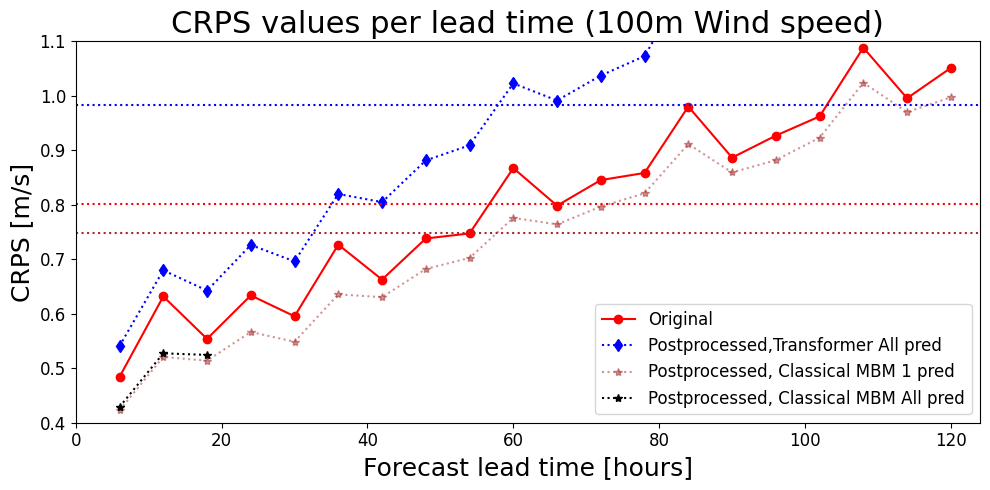

In [24]:
Leadtimes = obs.step.values
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 5))
plt.plot(Leadtimes, CRPS_OG, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF, color='blue',linestyle=':', marker='d' ,label='Postprocessed,Transformer All pred')
#plt.plot(Leadtimes, CRPS_TF_1, color='cyan',linestyle=':', marker='d' ,alpha=0.5,label='Postprocessed,Transformer 1 pred')
plt.plot(Leadtimes, CRPS_MBM_1, color='brown',linestyle=':', marker='*',alpha=0.5, label='Postprocessed, Classical MBM 1 pred')
plt.plot(Leadtimes[0:3], CRPS_MBM, color='black',linestyle=':', marker='*', label='Postprocessed, Classical MBM All pred')


plt.axhline(y=meanOG, color='red',linestyle=':')
plt.axhline(y=meantf, color='blue',linestyle=':')
#plt.axhline(y=meantf1, color='cyan',linestyle=':')
#plt.axhline(y=meanmbm, color='black',linestyle=':')
plt.axhline(y=meanmbm1, color='brown',linestyle=':')

# Set title and labels
plt.title('CRPS values per lead time (100m Wind speed)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [m/s]', fontsize=18)

# Set y-axis limits and x-axis ticks
plt.xlim(0,124)
plt.ylim(0.4,1.1)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()